# DifferentialEquations.jl

[DifferentialEquations.jl](https://docs.sciml.ai/DiffEqDocs/dev/index.html) is by far [the best](https://docs.sciml.ai/SciMLBenchmarksOutput/stable/MultiLanguage/ode_wrapper_packages/) free and open source differential equations solver (not just for Julia, for any language): it is orders of magnitude faster and has orders of mangitude more features than anything else out there. It can solve standard ODEs, Delay-DEs, stochastic DEs, PDEs, ADEs, event handling, 1000s of solvers for all tese DEs and many other features. It is the central part of a whole organization focused on scientific machine learning (SciML) and the basis for [ModelingToolkit.jl](https://docs.sciml.ai/ModelingToolkit/dev/), a library for building simulations from symbolic definitions.

Here we will focus on Ordinary Differential Equations (ODEs) solving and use the module `OrdinaryDiffEq` only.

## Defining and solving some ODEs

The way DifferentialEquations.jl works is quite straightforward:

1. Make your set of ODEs a Julia function `f`
2. Put `f`, an initial state and a parameter container into an `ODEProblem`.
2. Choose the solvers and the arguments of the solvers you will use (e.g. tolerances, etc.)
3. Give the `ODEProblem` as well as the auxiliary arguments to the function `solve`!

Let's see it in practice by solving the Thomas cyclical system

$$
\begin{aligned}
\dot{x} &= \sin(y) - bx\\
\dot{y} &= \sin(z) - by\\
\dot{z} &= \sin(x) - bz
\end{aligned}
$$

First step is to make this a Julia function `f`. There are different possibilities on how to define this `f`, but here we will focus on the simplest case, called "out of place". The function function must be in the form `f(u, p, t) -> udot`, which means that given a state `u`, parameters `p` and current time `t` it returns a state vector `udot` containing the rates of change $d\mathbf{x}/dt$. 
For both `u, udot` it is recommended to use **static vectors** `SVector` for ODEs with small number of variables.

In [7]:
import Pkg
Pkg.activate(joinpath(@__DIR__, ".."))

  Activating project at `~/documents/presentations/IntroductionToJulia-API-2025`


In [25]:
using OrdinaryDiffEqTsit5, CairoMakie
using StaticArrays: SVector

function thomas_rule(u, p, t)
    x,y,z = u
    b = p[1]
    xdot = sin(y) - b*x
    ydot = sin(z) - b*y
    zdot = sin(x) - b*z
    return SVector(xdot, ydot, zdot)
end

thomas_rule (generic function with 1 method)

Then set the initial state and parameter container

In [9]:
u₀ = SVector(1.0, 1.0, 2.0)
p₀ = [0.2]

1-element Vector{Float64}:
 0.2

then put everything into the `ODEProblem` structure:

In [10]:
# third argument is the timespan to solve in
timespan = (0.0, 1000.0)
prob = ODEProblem(thomas_rule, u₀, timespan, p₀)

ODEProblem with uType SVector{3, Float64} and tType Float64. In-place: false
timespan: (0.0, 1000.0)
u0: 3-element SVector{3, Float64} with indices SOneTo(3):
 1.0
 1.0
 2.0

Alright, so now we choose the solver algorithm to use. We will discuss this choice in more detail later, but for now we use the default choice of DifferentialEquations.jl.

In [11]:
alg = Tsit5();

Now let's solve the Lorenz system using the default settings of DifferentialEquations.jl (without specifying anything else).

In [12]:
sol = solve(prob; alg) # provide solver algorithm as keyword `alg`

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 820-element Vector{Float64}:
    0.0
    0.1120521120556666
    0.4437804997346293
    0.9136032182992833
    1.4662848775366266
    2.1996083627224228
    3.20452085399422
    4.0852429076339485
    5.129213664571065
    6.241262240376643
    ⋮
  993.8264914362611
  994.8288991175499
  995.7253894176727
  996.7583728083242
  997.6916520115195
  998.4266851434552
  999.0810614984777
  999.882278438528
 1000.0
u: 820-element Vector{SVector{3, Float64}}:
 [1.0, 1.0, 2.0]
 [1.073328946367455, 1.077382180107541, 2.0510228820916896]
 [1.3010643579265315, 1.2794416288151036, 2.2164023022205264]
 [1.6249069765414978, 1.4855826783233455, 2.4616668849694427]
 [1.977742536534128, 1.6017467329849024, 2.7100439701974253]
 [2.389498456629055, 1.5990898786761916, 2.8904410158701572]
 [2.864907454827271, 1.5483523439525533, 2.795240575931618]
 [3.208555992006444, 1.6972898094872602, 2.4194479636522503]
 [3.4778227966671613,

Okay, so what is the returned result? We didn't specify when to save or anything...

The solver we chose, `Tsit5`, is an _adaptive step solver_. The system is evolved with an adaptive step size, so that the step error tolerance stays below a pre-defined level. The system is evolved until we reach the end of the time span. A state is recorded at every step the solver algorithm takes naturally. E.g. the solution at the third step is

In [13]:
sol.t

820-element Vector{Float64}:
    0.0
    0.1120521120556666
    0.4437804997346293
    0.9136032182992833
    1.4662848775366266
    2.1996083627224228
    3.20452085399422
    4.0852429076339485
    5.129213664571065
    6.241262240376643
    ⋮
  993.8264914362611
  994.8288991175499
  995.7253894176727
  996.7583728083242
  997.6916520115195
  998.4266851434552
  999.0810614984777
  999.882278438528
 1000.0

The solution is guaranteed to start and stop at the limits of the time span (by default).

We can obtain the state at the 3rd time point from the `u` field:

In [14]:
(sol.t[3], sol.u[3])

(0.4437804997346293, [1.3010643579265315, 1.2794416288151036, 2.2164023022205264])

Because of the mechanics of the solver, `sol` object allows arbitrary interpolation in time by saving some extra derivative-related numbers. This means that we can use `sol` as a function of time, `sol(t)`, to obtain the solution at time `t`

In [15]:
sol(5.6)

3-element SVector{3, Float64} with indices SOneTo(3):
 3.495862758880764
 2.4335212819504655
 1.4402755298956589

We can iterate over some time to create a (multivariate) timeseries

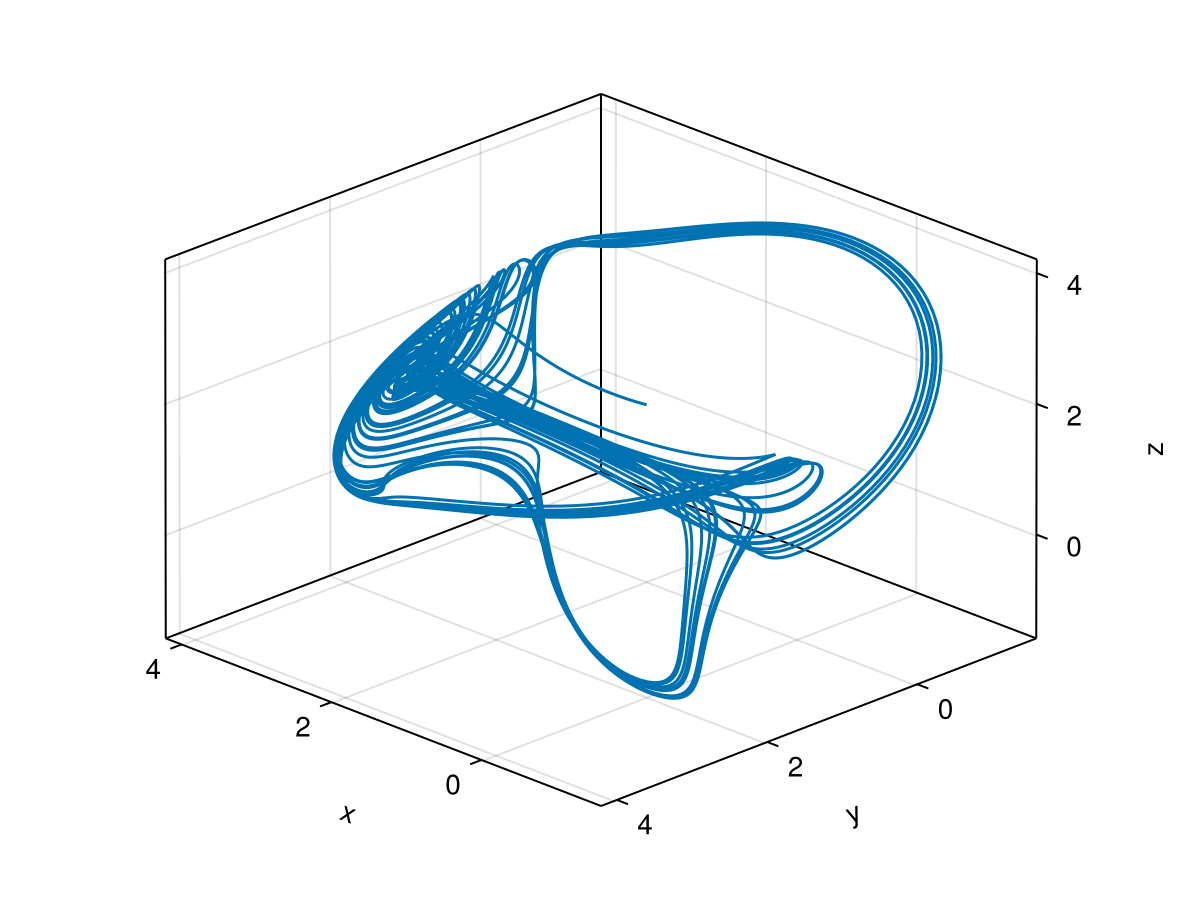

In [26]:
t = timespan[1]:0.1:timespan[end]
X, Y, Z = zero(t), zero(t), zero(t)
for (i, τ) in enumerate(t)
    X[i], Y[i], Z[i] = sol(τ)
end
lines(X, Y, Z; axis = (type = Axis3, azimuth = 0.75π))

Notice that it is possible to skip this advanced feature of interpolation (and thus also skip collecting the extra interpolation-related numbers) and only save at some pre-defined time points by passing the extra keyword argument `saveat = points_I_want` to the `solve` call.

In [17]:
t = timespan[1]:0.1:timespan[end]
sol = solve(prob; alg, saveat = t)
sol.t

10001-element Vector{Float64}:
    0.0
    0.1
    0.2
    0.3
    0.4
    0.5
    0.6
    0.7
    0.8
    0.9
    ⋮
  999.2
  999.3
  999.4
  999.5
  999.6
  999.7
  999.8
  999.9
 1000.0

## Using callbacks for triggering events during time evolution

DifferentialEquations.jl implements a simple interface so that "events" (arbitrary things) can be triggered to after your solution as it is progressing in time. This is done with the [`Callback` interface](https://docs.sciml.ai/DiffEqDocs/dev/features/callback_functions/). For example, a `ContinuousCallback` represents an event that "triggers" when a continuous univariate function of the (state, time) reaches the value 0. Similarly, a `DiscreteCallback` triggers when a Boolean function of the (state, time) evaluates to `true`.

Let's modify the Thomas cyclical system so that a condition triggers each time the third variable becomes zero:


In [18]:
# The third argument of this function is mandatory but too advanced for this lecture
condition(u, t, integrator) = u[3]

condition (generic function with 1 method)

We then define a function that modifies the integrator object. the integrator object is too complicated to explain within this lecture; but we mainly care about the fields `.u` and `.p` that access current state and parameter values. 

In [19]:
function affect!(integrator)
    integrator.u = 1.5integrator.u
end

affect! (generic function with 1 method)

The trigger `condition` and how it will `affect!` the integration are wrapped in continuous callback, which is given to the `solve` call.

In [20]:
cb = ContinuousCallback(condition, affect!);

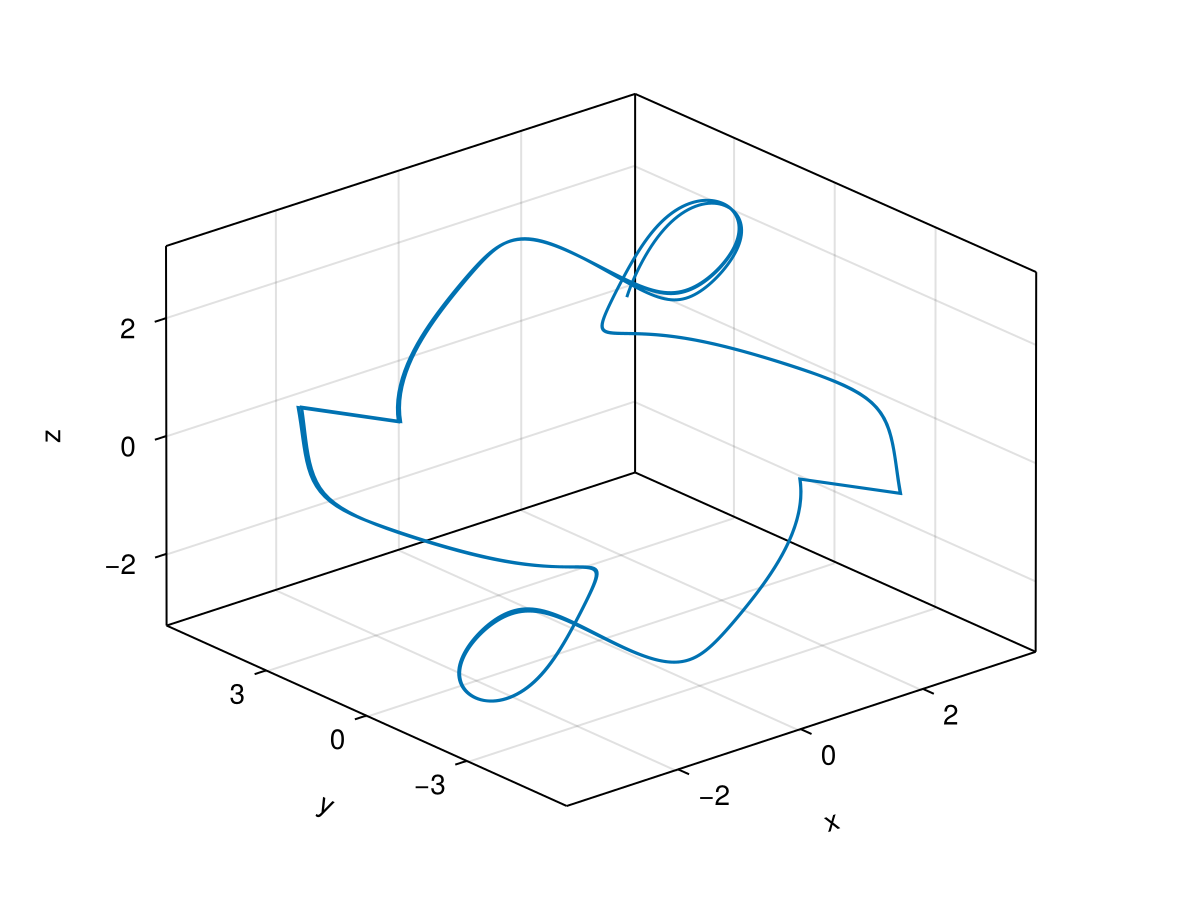

In [27]:
sol = solve(prob; alg, saveat = t, callback = cb)
# plot
lines(sol.u; axis = (type = Axis3,))

## Choosing a solver

So far we have not discussed _how_ the ODE is solved. 
A solver algorithm is chosen when a solution is requested.
So far we have been using `Tsit5`, which is also the overall default that DifferentialEquations.jl uses. But, DifferentialEquations.jl has an impressive list of [100s of solvers one can choose from](https://docs.sciml.ai/DiffEqDocs/dev/solvers/ode_solve/).

Choosing the solver is a problem-dependent operation. We'll cover here two typical examples.




### Higher accuracy, higher order

The solver `Tsit5` is most performant when medium-high error tolerances are requested. When we require very small errors, choosing a different solver can be more accurate. This can be especially impactful for chaotic dynamical systems. Let's first explicitly ask for a given accuracy when solving the ODE by passing the keywords `abstol, reltol` (for absolute and relative tolerance respectively):


In [28]:
using OrdinaryDiffEqVerner

In [22]:
sol = solve(prob; alg, saveat = t, abstol = 1e-12, reltol = 1e-12)
sol[end]

3-element SVector{3, Float64} with indices SOneTo(3):
 2.5171692944872692
 3.053033471019527
 2.1309387329252925

Let's now benchmark how much time it takes to solve the problem with the default `Tsit5` solver:

In [23]:
using BenchmarkTools
@btime solve(prob; alg, saveat = t, abstol = 1e-12, reltol = 1e-12);

  8.537 ms (43 allocations: 719.16 KiB)


Let's see how the higher-order solver `Vern9`, which is better suited for high accuracy, performs:

In [29]:
using BenchmarkTools
@btime solve(prob; alg = Vern9(), saveat = t, abstol = 1e-12, reltol = 1e-12);

  3.718 ms (44 allocations: 720.31 KiB)


## Stiff problems

A "stiff" ODE problem is one that can be numerically unstable unless the step size (or equivalently, the step error tolerances) are extremely small. There are several situations where a problem may be come "stiff":

- The derivative values can get very large for some state values.
- There is a large _timescale separation_ between the dynamics of the variables
- There is a large _timescale separation_ between the dynamics of different state space regions

One must be aware whether this is possible for their system and choose a solver that is better suited to tackle stiff problems. If not, a solution may diverge and the ODE integrator will throw an error or a warning.

  Many of the problems in DifferentialEquations.jl are suitable for dealing with stiff problems, such as `Rodas5P()`. Consult the solver documentation for the possibilities.

# Exercises


## Bouncing ball

Using the callback functionality of DifferentialEquations.jl, implement the bouncing ball physical system:

$$
\begin{aligned}
\dot{x} &= v \\
\dot{v} &= -g - \gamma v 
\end{aligned}
$$
and at $x=0$ there is a table that the ball bounces from. $g$ is the gravity constant and $\gamma$ the air friction (use e.g. $g=10, \gamma = 0.99, x = 1, v = 0$). Implement this problem for elastic collisions (elastic collisions preserve velocity measure), and plot the time evolution of $x, v$ versus time.

*Hint: whenever the ball reaches the level $x=0$, its velocity should be reversed.*

## The N-body problem

The n-body problem involves solving a second-order differential equation. Normally this is solved by writing a coupled first-order differential equation, with 

$$\vec{u} = \begin{bmatrix} \vec{r} \\ \vec{v} \end{bmatrix}, \qquad \frac{d \vec{u}}{dt} = \begin{bmatrix} \vec{v} \\ \vec{a} \end{bmatrix} $$

where $\vec{r}$ is the positional vector, $\vec{v}$ is the velocity vector, $\vec{a}$ is the acceleration vector given by

$$\vec{a}_i = \sum_{i=1, i \neq j}^N -G\frac{m_j}{r_{ij}^2}\frac{\vec{r_{ij}}}{r_{ij}}.$$

With $\vec{r}_{ij} = \vec{r}_i - \vec{r}_j$, and $r_{ij} = |\vec{r}_{ij}|$.

Write a code for solving the N-body problem. Try with 2, 3, 4, or more particles. Experiment with different solvers. 

### Bonus exercise

 `DifferentialEquations.jl` contains solvers specialized for second-order ODEs, which may in some cases provide better performance and accuracy on specific problems. Write your N-body solver to be in the form of a 2nd order differential equation, and solve it using one of the [second order solvers](https://docs.sciml.ai/DiffEqDocs/stable/types/dynamical_types/). Benchmark your code with the first-order version. Do you see a difference in performance and/or accuracy?